# 1. 분류
#### 지도 학습 : 명시적인 정답이 있는 데이터가 주어진 상태에서 학습하는 머신러닝 방식이다.
#### 분류 : 지도학습의 대표적인 유형, 학습 데이터로 주어진 데이터의 피처와 레이블 값을 머신러닝 알고리즘으로 학습해 모델 생성 후 새로운 레이블 값을 예측하는 것이다.

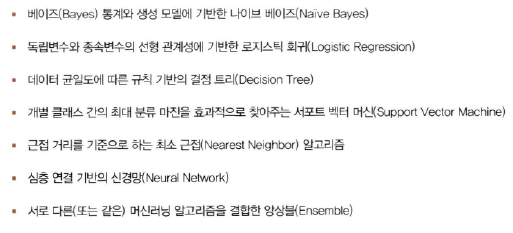

#### 이 장에서는 앙상블 방법의 개요와 랜덤 포레스트, 그래디언트 부스팅의 전통적인 앙상블 기법 학습하고, 부스팅 계열인 XGBoost와 LightGBM, 그리고 스태킹(Stacking) 기법에 대해서 알아볼 것이다.
#### 앙상블이 서로 다른 또는 같은 알고리즘을 결합한다고 했는데, 대부분은 동일한 알고리즘을 결합한다.
#### 앙상블의 기본 알고리즘으로는 일반적으로 결정트리를 사용한다.

# 2. 결정 트리
#### 데이터에 있는 규칙을 학습을 통해 자동으로 찾아내 트리 기반의 분류 규칙을 만드는 것이다.

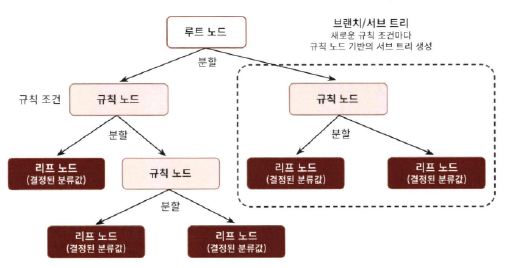

## 결정 트리 모델 특징
#### 많은 규칙이 있다는 건 복잡해진다는 의미이고, 곧 과적합으로 이어지기 쉽다. 그래서 가능한 적은 결정 노드로 예측 정확도를 높여야 한다.
#### 그래서 최대한 균일한 데이터 세트를 구성할 수 있도록 분할하는 것이 중요하다.
#### 정보의 균일도를 측정하는 방법에는 정보 이득 지수와 지니 계수가 있다.

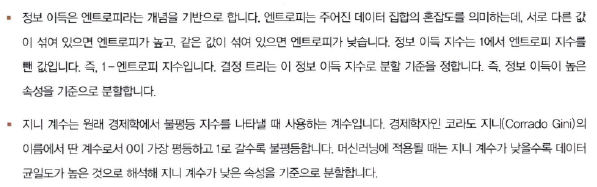

#### 정보의 균일도만 신경 쓰면 되므로 대부분 각 피처의 스케일링과 정규화 같은 전저리 작업은 필요 없다.

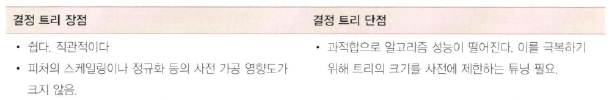

## 결정 트리 파라미터(사이킷런)
#### 분류 - DecisionTreeClassifier, 회귀 - DecisionTreeRegressor

## 결정 트리 모델 시각화
#### Graphviz 패키지 사용

In [5]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

dt_clf = DecisionTreeClassifier(random_state=156)

iris_data = load_iris()
X_train, X_test, y_train, y_test = train_test_split(iris_data.data, iris_data.target, test_size=0.2, random_state=11)

dt_clf.fit(X_train, y_train)

DecisionTreeClassifier(random_state=156)

In [6]:
from sklearn.tree import export_graphviz

# export_graphviz()의 호출 결과로 out_file로 지정된 tree.dot 파일을 생성함
export_graphviz(dt_clf, out_file="tree.dot", class_names=iris_data.target_names, \
               feature_names = iris_data.feature_names, impurity=True, filled=True)

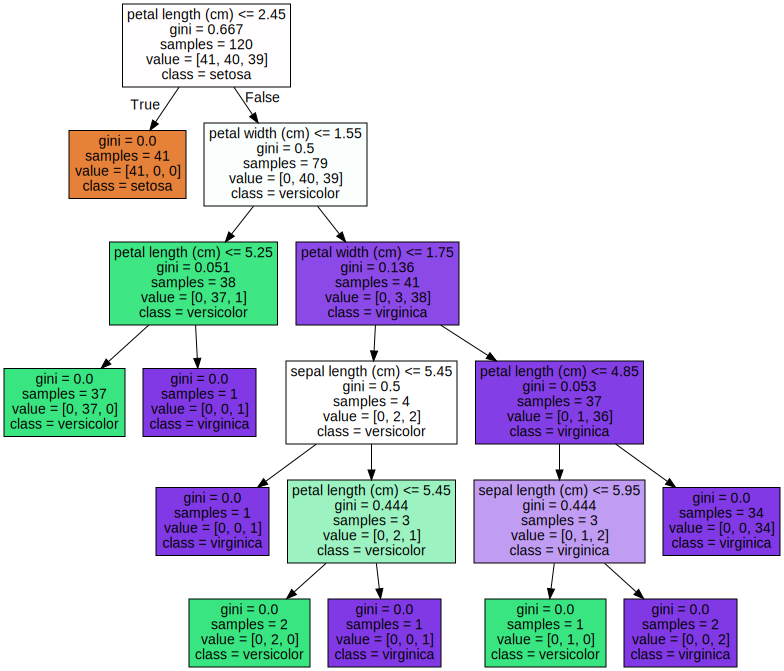

In [7]:
import graphviz

with open("tree.dot") as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

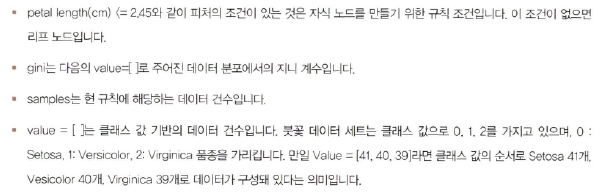

#### 결정 트리의 하이퍼 파라미터 변경에 따른 트리의 변화로 간단한 결정 트리를 만들 수 있다.
#### ex) max_depth(결정 트리 깊이), min_sample_splits(최소한의 자식 노드 샘플 수),  min_samples_leaf(최소한의 리포 노드 샘플 수)
#### 피처 중요도 확인(feature_importances_)

피처 중요도 : [0.025 0.    0.555 0.42 ]
sepal length (cm) : 0.025
sepal width (cm) : 0.000
petal length (cm) : 0.555
petal width (cm) : 0.420


<Axes: >

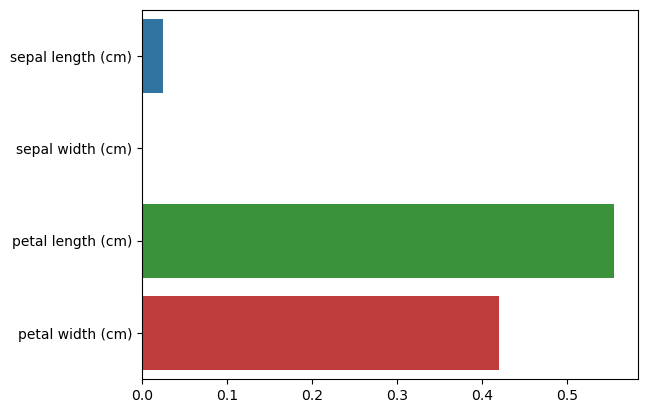

In [10]:
import seaborn as sns
import numpy as np
%matplotlib inline

print("피처 중요도 : {0}".format(np.round(dt_clf.feature_importances_, 3)))

for name, value in zip(iris_data.feature_names, dt_clf.feature_importances_):
    print('{0} : {1:.3f}'.format(name, value))
    
sns.barplot(x=dt_clf.feature_importances_, y=iris_data.feature_names)

## 결정 트리 과적합(Overfitting)

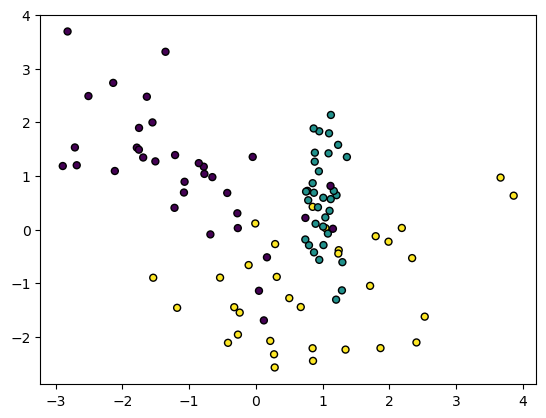

In [13]:
from sklearn.datasets import make_classification
import matplotlib.pyplot as plt
%matplotlib inline

# 2차원 시각화를 위해서 피처는 2개, 클래스는 3가지 유형의 분류 샘플 데이터 생성
X_features, y_labels = make_classification(n_features=2, n_redundant=0, n_informative=2, n_classes=3, n_clusters_per_class=1, random_state=0)
plt.scatter(X_features[:, 0], X_features[:, 1], marker='o', c=y_labels, s=25, edgecolors='k')

In [15]:
import numpy as np

# Classifier의 Decision Boundary를 시각화 하는 함수
def visualize_boundary(model, X, y):
    fig,ax = plt.subplots()
    
    # 학습 데이타 scatter plot으로 나타내기
    ax.scatter(X[:, 0], X[:, 1], c=y, s=25, cmap='rainbow', edgecolor='k',
               clim=(y.min(), y.max()), zorder=3)
    ax.axis('tight')
    ax.axis('off')
    xlim_start , xlim_end = ax.get_xlim()
    ylim_start , ylim_end = ax.get_ylim()
    
    # 호출 파라미터로 들어온 training 데이타로 model 학습 . 
    model.fit(X, y)
    # meshgrid 형태인 모든 좌표값으로 예측 수행. 
    xx, yy = np.meshgrid(np.linspace(xlim_start,xlim_end, num=200),np.linspace(ylim_start,ylim_end, num=200))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    
    # contourf() 를 이용하여 class boundary 를 visualization 수행. 
    n_classes = len(np.unique(y))
    contours = ax.contourf(xx, yy, Z, alpha=0.3,
                           levels=np.arange(n_classes + 1) - 0.5,
                           cmap='rainbow', clim=(y.min(), y.max()),
                           zorder=1)

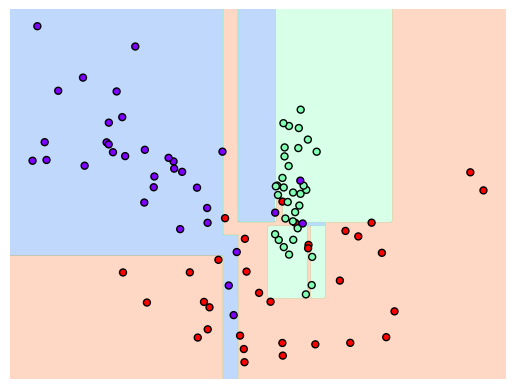

In [16]:
from sklearn.tree import DecisionTreeClassifier

dt_clf = DecisionTreeClassifier(random_state=156).fit(X_features, y_labels)
visualize_boundary(dt_clf, X_features, y_labels)

#### 일부 이상치 데이터까지 분류하기 위해선 결정 기준이 복잡해지면서 데이터 특성이 약간 다르다면 예측 정확도가 떨어진다.
#### 하이퍼 파라미터를 조정하여 결정 기준 경계를 확인해보자

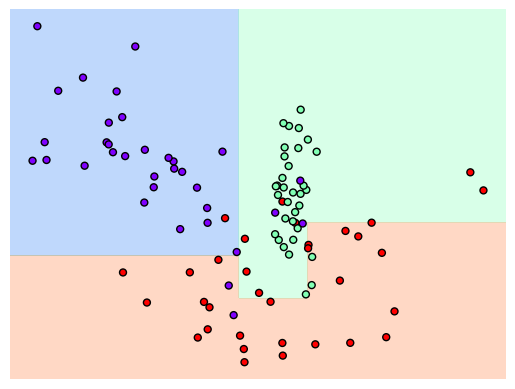

In [17]:
dt_clf = DecisionTreeClassifier(min_samples_leaf=6, random_state=156).fit(X_features, y_labels)
visualize_boundary(dt_clf, X_features, y_labels)

#### 좀 더 일반환된 분류 규칙에 따라 분류되었다.
#### 학습 데이터에만 지나치게 최적화된 분류 기준은 오히려 테스트 데이터에서 정확도를 떨어뜨릴 수 있다!

## 결정 트리 실습 - 사용자 행동 인식 데이터 세트
#### README.txt와 features_info.txt 파일에는 데이터 세트와 피처에 대한 간략한 설명이 적혀 있습니다.
#### features.txt에는 피처의 이름이 기술돼 있습니다.
#### activity_labels.txt는 동작 레이블 값에 대한 설명이 있습니다.
#### train과 test 디렉터리에는 학습(Train) 용도의 피처 데이터 세트와 레이블 데이터 세트 테스트(Test)용 피처 데이터 세트와 클래스 값 데이터 세트가 들어 있습니다.

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

feature_name_df = pd.read_csv('C:\machine_learning_guide\DATA\human_activity\\features.txt', sep='\s+', header=None, names=['columns_index', 'column_name'])

feature_name = feature_name_df.iloc[:, 1].values.tolist()
print(feature_name[:10])

['tBodyAcc-mean()-X', 'tBodyAcc-mean()-Y', 'tBodyAcc-mean()-Z', 'tBodyAcc-std()-X', 'tBodyAcc-std()-Y', 'tBodyAcc-std()-Z', 'tBodyAcc-mad()-X', 'tBodyAcc-mad()-Y', 'tBodyAcc-mad()-Z', 'tBodyAcc-max()-X']


#### 중복된 피처명에 대한 처리가 필요하다 -> 원본 피처명에 _1 또는 _2를 추가로 부여하자

In [30]:
feature_dup_df = feature_name_df.groupby('column_name').count()
print(feature_dup_df[feature_dup_df['columns_index'] > 1].count())
feature_dup_df[feature_dup_df['columns_index'] > 1].head()

columns_index    42
dtype: int64


,columns_index
column_name,
"fBodyAcc-bandsEnergy()-1,16",3
"fBodyAcc-bandsEnergy()-1,24",3
"fBodyAcc-bandsEnergy()-1,8",3
"fBodyAcc-bandsEnergy()-17,24",3
"fBodyAcc-bandsEnergy()-17,32",3


In [31]:
def get_new_feature_name_df(old_feature_name_df):
    feature_dup_df = pd.DataFrame(data=old_feature_name_df.groupby('column_name').cumcount(),
                                  columns=['dup_cnt'])
    feature_dup_df = feature_dup_df.reset_index()
    new_feature_name_df = pd.merge(old_feature_name_df.reset_index(), feature_dup_df, how='outer')
    new_feature_name_df['column_name'] = new_feature_name_df[['column_name', 'dup_cnt']].apply(lambda x : x[0]+'_'+str(x[1]) 
                                                                                         if x[1] >0 else x[0],  axis=1)
    new_feature_name_df = new_feature_name_df.drop(['index'], axis=1)
    return new_feature_name_df

In [36]:
import pandas as pd

def get_human_dataset( ):
    
    # 각 데이터 파일들은 공백으로 분리되어 있으므로 read_csv에서 공백 문자를 sep으로 할당.
    feature_name_df = pd.read_csv('C:\machine_learning_guide\DATA\human_activity\\features.txt',sep='\s+',
                        header=None,names=['column_index','column_name'])
    
    # 중복된 피처명을 수정하는 get_new_feature_name_df()를 이용, 신규 피처명 DataFrame생성. 
    new_feature_name_df = get_new_feature_name_df(feature_name_df)
    
    # DataFrame에 피처명을 컬럼으로 부여하기 위해 리스트 객체로 다시 변환
    feature_name = new_feature_name_df.iloc[:, 1].values.tolist()
    
    # 학습 피처 데이터 셋과 테스트 피처 데이터을 DataFrame으로 로딩. 컬럼명은 feature_name 적용
    X_train = pd.read_csv('C:\machine_learning_guide\DATA\human_activity\\train\\X_train.txt',sep='\s+', names=feature_name )
    X_test = pd.read_csv('C:\machine_learning_guide\DATA\human_activity\\test\\X_test.txt',sep='\s+', names=feature_name)
    
    # 학습 레이블과 테스트 레이블 데이터을 DataFrame으로 로딩하고 컬럼명은 action으로 부여
    y_train = pd.read_csv('C:\machine_learning_guide\DATA\human_activity\\train\\y_train.txt',sep='\s+',header=None,names=['action'])
    y_test = pd.read_csv('C:\machine_learning_guide\DATA\human_activity\\test\\y_test.txt',sep='\s+',header=None,names=['action'])
    
    # 로드된 학습/테스트용 DataFrame을 모두 반환 
    return X_train, X_test, y_train, y_test


X_train, X_test, y_train, y_test = get_human_dataset()

In [37]:
print(X_train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7352 entries, 0 to 7351
Columns: 561 entries, tBodyAcc-mean()-X to angle(Z,gravityMean)
dtypes: float64(561)
memory usage: 31.5 MB
None


In [39]:
print(y_train['action'].value_counts())

6    1407
5    1374
4    1286
1    1226
2    1073
3     986
Name: action, dtype: int64


In [40]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

dt_clf = DecisionTreeClassifier(random_state=156)
dt_clf.fit(X_train, y_train)
pred = dt_clf.predict(X_test)
accuracy = accuracy_score(y_test, pred)
print('{0:.4f}'.format(accuracy))

0.8548


In [41]:
print('DecisionTreeClassifier 기본 하이퍼 파라미터:', dt_clf.get_params())

DecisionTreeClassifier 기본 하이퍼 파라미터: {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 156, 'splitter': 'best'}


#### GridSearchCV를 이용해 max_depth 값을 변화시키며 예측 성능 확인해보자

In [43]:
from sklearn.model_selection import GridSearchCV

params = {
    'max_depth' : [6, 8, 10, 12, 16, 20, 24],
    'min_samples_split': [16]
}

grid_cv = GridSearchCV(dt_clf, param_grid=params, scoring='accuracy', cv=5, verbose=1)
grid_cv.fit(X_train, y_train)
print("최고 정확도 수치 : {0:.4f}".format(grid_cv.best_score_))
print("최적 하이퍼 파라미터 :", grid_cv.best_params_)

Fitting 5 folds for each of 7 candidates, totalling 35 fits
최고 정확도 수치 : 0.8549
최적 하이퍼 파라미터 : {'max_depth': 8, 'min_samples_split': 16}


In [45]:
cv_results_df = pd.DataFrame(grid_cv.cv_results_)

cv_results_df[['param_max_depth', 'mean_test_score']]

,param_max_depth,mean_test_score
0,6,0.847662
1,8,0.854879
2,10,0.852705
3,12,0.845768
4,16,0.847127
5,20,0.848624
6,24,0.848624


#### max_depth가 8일 때 0.854로 정확도가 정점이고, 이를 넘어가면 정확도가 계속 떨어진다.

In [46]:
max_depths = [6, 8, 10, 12, 16, 20, 24]
for depth in max_depths:
    dt_clf = DecisionTreeClassifier(max_depth=depth, min_samples_split=16, random_state=156)
    dt_clf.fit(X_train,y_train)
    pred = dt_clf.predict(X_test)
    accuracy = accuracy_score(y_test, pred)
    print('max_depth : {0} 정확도 : {1:.4f}'.format(depth, accuracy))

max_depth : 6 정확도 : 0.8551
max_depth : 8 정확도 : 0.8717
max_depth : 10 정확도 : 0.8599
max_depth : 12 정확도 : 0.8571
max_depth : 16 정확도 : 0.8599
max_depth : 20 정확도 : 0.8565
max_depth : 24 정확도 : 0.8565


#### 테스트 세트도 max_depth가 8일 때 정확도가 가장 정점이다.
#### max_depth와 min_sample_split을 같이 변경하면서 정확도 성능을 튜닝해보자

In [47]:
params = {
    'max_depth' : [8, 12, 16, 20],
    'min_samples_split': [16, 24]
}

grid_cv = GridSearchCV(dt_clf, param_grid=params, scoring='accuracy', cv=5, verbose=1)
grid_cv.fit(X_train, y_train)
print("최고 정확도 수치 : {0:.4f}".format(grid_cv.best_score_))
print("최적 하이퍼 파라미터 :", grid_cv.best_params_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
최고 정확도 수치 : 0.8549
최적 하이퍼 파라미터 : {'max_depth': 8, 'min_samples_split': 16}


#### max_depth : 8, min_samples_split : 16 -> 최고 정확도

In [48]:
best_df_clf = grid_cv.best_estimator_
pred1 = best_df_clf.predict(X_test)
accuracy = accuracy_score(y_test, pred1)
print('정확도 : {0:.4f}'.format(accuracy))

정확도 : 0.8717


#### 각 피처의 중요도 확인(feature_importances_ 속성 사용)

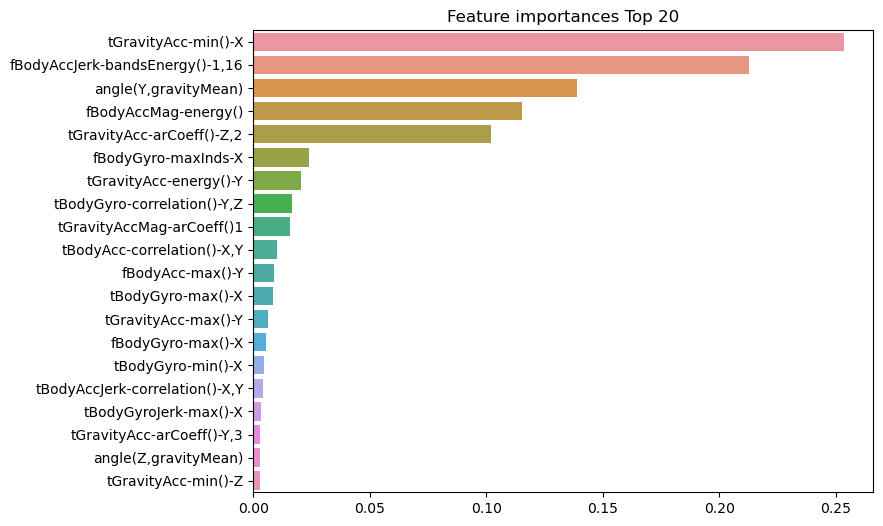

In [49]:
ftr_importances_values = best_df_clf.feature_importances_
# Top 중요도로 정렬을 쉽게 하고, 시본(Seaborn)의 막대그래프로 쉽게 표현하기 위해 Series변환
ftr_importances = pd.Series(ftr_importances_values, index=X_train.columns  )
# 중요도값 순으로 Series를 정렬
ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]
plt.figure(figsize=(8,6))
plt.title('Feature importances Top 20')
sns.barplot(x=ftr_top20 , y = ftr_top20.index)
plt.show()

#### 상위 5개의 피처가 규칙 생성에 중요하게 영향을 미치고 있다!

# 3. 앙상블 학습
#### 앙상블 학습을 통한 분류란 여러 개의 분류기를 생성하고 그 예측을 결합함으로써 보다 정확한 최종 예측을 도출하는 기법이다. (집단 지성)
#### 랜덤 포레스트, 그래디언트 부스팅, XGBoost, LightGBM, Stacking
#### 앙상블 학습 유형 : 보팅(Voting), 배깅(Bagging), 부스팅(Boosting), 스태깅(Stacking)

#### 보팅과 배깅은 여러 개의 분류기가 투표를 통해 최종 예측 결과를 결정하는 방식
#### 다른 점은 보팅의 경우 일반적으로 서로 다른 알고리즘을 가진 분류기를 결합하는 것이고, 배깅의 경우 각각의 분류기가 모두 같은 유형의 알고리즘이지만 데이터 샘플링을 각각 다르게 가져가면서 학습을 수행(부트스트래핑 분할 방식)해 보팅 수행한다.
#### 배깅 - 대표적 알고리즘은 랜덤 포레스트 알고리즘

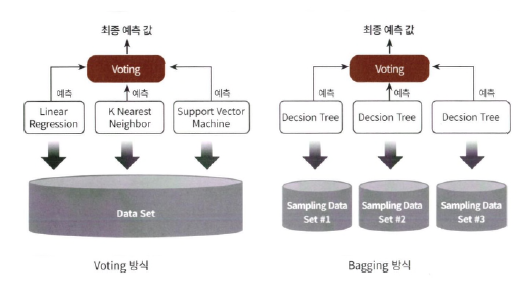

#### 부스팅은 여러 개의 분류기가 순차적으로 학습을 수행하되, 앞에서 학습한 분류기가 예측이 틀린 데이터에 올바르게 예측할 수 있도록 다음 분류기에 가중치를 부여하면서 학습과 예측을 수행한다. - XGBoost, LightGBM
#### 스태킹은 여러 가지 다른 모델의 예측 결과값을 다시 학습 데이터로 만들어서 다른 모델로 재학습시켜 결과를 예측하는 방법이다.

## 보팅 - 하드 보팅과 소프트 보팅
#### 하드 보팅 : 예측한 결과값들 중 다수의 분류기가 결정한 예측값을 최종 보팅 결과값으로 선정
#### 소프트 보팅 : 분류기들의 레이블 값 결정 확률을 모두 더하고 이를 평균해서 이들 중 확률이 가장 높은 레이블 값을 최종 보팅 결과값으로 선정

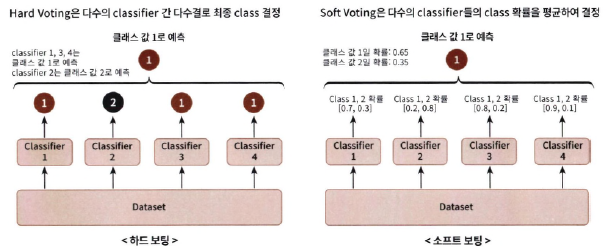

## 보팅 분류기 : VotingClassifier(사이킷런)

In [50]:
import pandas as pd

from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import warnings 
warnings.filterwarnings('ignore')

cancer = load_breast_cancer()

data_df = pd.DataFrame(cancer.data, columns=cancer.feature_names)
data_df.head(3)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758


In [53]:
# 개별 모델은 로직스틱 회귀와 KNN이다.
lr_clf = LogisticRegression(solver='liblinear')
knn_clf = KNeighborsClassifier(n_neighbors=8)

# 개별 모델을 소프트 보팅 기반의 앙상블 모델로 구현한 분류기(기본은 'hard')
vo_clf = VotingClassifier(estimators=[('LR', lr_clf), ('KNN', knn_clf)], voting='soft')
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, test_size=0.2, random_state=156)

In [54]:
vo_clf.fit(X_train, y_train)
pred = vo_clf.predict(X_test)
print('Voting 정확도 : {0:.4f}'.format(accuracy_score(y_test, pred)))

Voting 정확도 : 0.9561


In [55]:
# 개별 모델의 학습/예측/평가.
classifiers = [lr_clf, knn_clf]
for classifier in classifiers:
    classifier.fit(X_train , y_train)
    pred = classifier.predict(X_test)
    class_name= classifier.__class__.__name__
    print('{0} 정확도: {1:.4f}'.format(class_name, accuracy_score(y_test , pred)))

LogisticRegression 정확도: 0.9474
KNeighborsClassifier 정확도: 0.9386


#### 앙상블 방법은 전박적으로 다른 단일 ML 알고리즘보다 뛰어난 예측 성능을 가지는 경우가 많다.
#### 보팅, 스태깅은 서로 다른 알고리즘을 기반으로 하지만, 배깅과 부스팅은 대부분 결정 트리 알고리즘을 기반으로 한다. 결정 트리의 단점이 있지만 수십~수천 개의 많은 분류기를 결합하여 다양한 상황을 학습함으로써 극복하고 있다.

## 4. 랜덤 포레스트
#### 배깅의 대표적인 알고리즘으로써 같은 알고리즘으로 여러 개의 분류기를 만들어서 보팅으로 최종 결정하는 알고리즘(각각 데이터 샘플링 - 부트스트래핑 분할 방식)

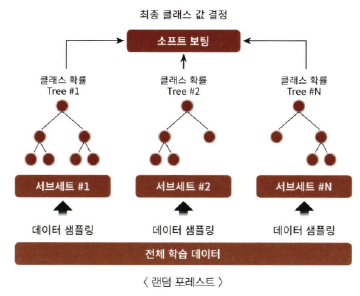

#### 랜덤 포레스트는 개별 트리가 학습하는 데이터 세트는 전체 데이터에서 일부가 중첩되게 샘플링된 데이터 세트이다.
#### 이렇게 여러 개의 데이터 세트를 중첩되게 분리하는 것을 부트스트래핑 분할 방식이라고 한다.(Bagging = boostrap aggregating 줄임말)
#### 랜덤 포레스트의 서브세트 데이터 건수는 전체 데이터 건수와 동일하지만, 개별 데이터가 중첩되어 만들어진다.
#### 원본 데이터 개수가 10개인 학습 데이터 세트에서 랜덤 포레스트를 3개의 결정 트리 기반으로 학습하려고 n_estimators=3으로 하이퍼 파라미터를 부여하면 아래와 같이 만들어진다.

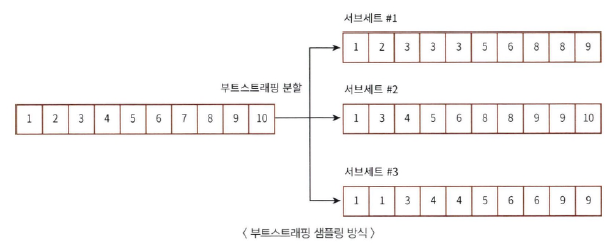

## 랜덤 포레스트 분류 - RandomForestClassifier(사이킷런)

In [56]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# 결정 트리에서 사용한 get_human_dataset( )을 이용해 학습/테스트용 DataFrame 반환
X_train, X_test, y_train, y_test = get_human_dataset()

In [57]:
rf_clf = RandomForestClassifier(random_state=0, max_depth=8)
rf_clf.fit(X_train, y_train)
pred = rf_clf.predict(X_test)
accuracy = accuracy_score(y_test, pred)
print('랜덤 포레스트 정확도 : {0:.4f}'.format(accuracy))

랜덤 포레스트 정확도 : 0.9196


## 랜덤 포레스트 하이퍼 파라미터 및 튜닝
#### 트리 기반의 앙상블 알고리즘의 단점은 하이퍼 파라미터가 너무 많고, 튜닝 시간이 오래 걸린다는 것이다. 더구나 튜닝 후 예측 성능이 크게 향상되는 경우가 많지 않다.

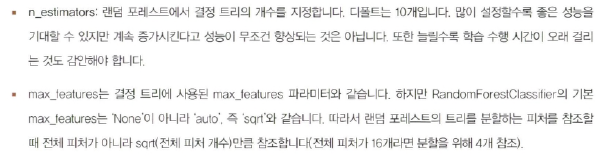
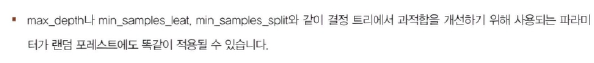

In [58]:
from sklearn.model_selection import GridSearchCV

params = {
    'max_depth': [8, 16, 24],
    'min_samples_leaf': [1, 6, 12],
    'min_samples_split': [2, 8, 16]
}

rf_clf = RandomForestClassifier(n_estimators=100, random_state=0, n_jobs=-1)
grid_cv = GridSearchCV(rf_clf, param_grid=params, cv=2, n_jobs=-1)
grid_cv.fit(X_train, y_train)

print('최적 하이퍼 파라미터 :', grid_cv.best_params_)
print('최고 예측 정확도 : {0:.4f}'.format(grid_cv.best_score_))

최적 하이퍼 파라미터 : {'max_depth': 16, 'min_samples_leaf': 6, 'min_samples_split': 2}
최고 예측 정확도 : 0.9165


In [59]:
rf_clf1 = RandomForestClassifier(n_estimators=100, min_samples_leaf=6, max_depth=16, min_samples_split=2, random_state=0)
rf_clf1.fit(X_train, y_train)
pred = rf_clf1.predict(X_test)
print("예측 정확도 : {0:.4f}".format(accuracy_score(y_test, pred)))

예측 정확도 : 0.9260


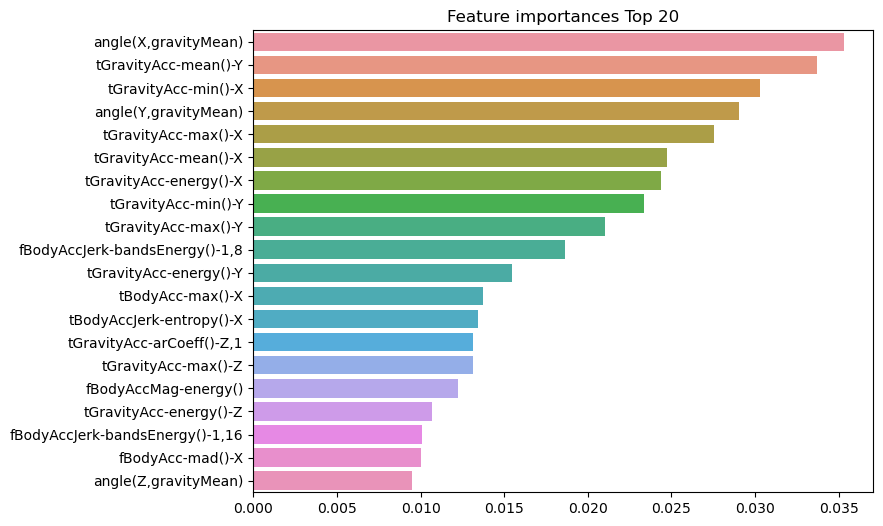

In [60]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

ftr_importances_values = rf_clf1.feature_importances_
ftr_importances = pd.Series(ftr_importances_values,index=X_train.columns  )
ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]

plt.figure(figsize=(8,6))
plt.title('Feature importances Top 20')
sns.barplot(x=ftr_top20 , y = ftr_top20.index)
plt.show()